<h1><center><font size="25">Skforecast: forecasting series temporales con Python y scikit-learn</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

+ [Skforecast: GitHub](https://github.com/JoaquinAmatRodrigo/skforecast)
+ [Skforecast: Docs](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html)
+ [Artículos Skforecast](https://joaquinamatrodrigo.github.io/skforecast/latest/examples/examples.html)

## Librerias

In [1]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.0/217.0 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 4.6 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=d66404d67d6367a28acb937736adac3682363695ebb

In [3]:
# Librerias
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn y modelos
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Single series forecasting
from skforecast.ForecasterAutoreg import ForecasterAutoreg            
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

# Multiseries forecasting
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

## Datos

In [4]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',', usecols=['fecha', 'y'])

# Data preparation
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y-%m-%d')
data = data.set_index('fecha')
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y
fecha,
1992-04-01,0.379808
1992-05-01,0.361801
1992-06-01,0.410534
1992-07-01,0.483389
1992-08-01,0.475463


Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


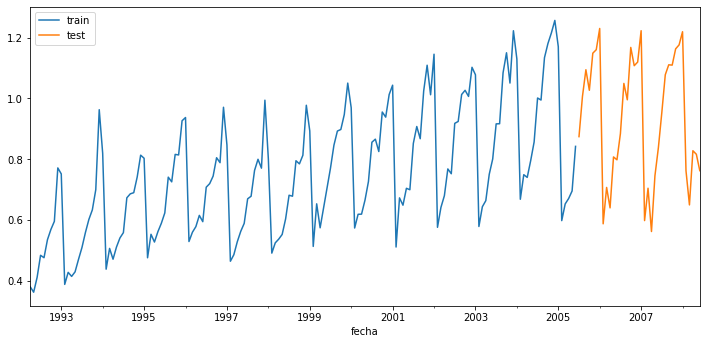

In [5]:
# Split data into train-val-test
# ==============================================================================
steps = 36 # Separamos 36 meses como periodo de test
data_train = data[:-steps]
data_test = data[-steps:]

print(f"Fechas train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Fechas test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(12, 5.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

## Forecasting autorregresivo recursivo

In [6]:
# Crear y ajustar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = RandomForestRegressor(random_state=123),
                 lags             = 12,
                 transformer_y    = None,    # transformación serie y
                 transformer_exog = None,    # transformación exógenas 
                 weight_func      = None     # pesos observaciones serie temporal según índice
             )

forecaster.fit(y=data_train['y'], exog=None)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-16 19:09:28 
Last fit date: 2023-02-16 19:09:28 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [7]:
# Predicciones
# ==============================================================================
steps = 36 # steps a predecir, 36 meses
predicciones = forecaster.predict(steps=steps, last_window=None)
predicciones.head(5)

2005-07-01    0.932374
2005-08-01    0.965877
2005-09-01    1.110397
2005-10-01    1.135135
2005-11-01    1.142431
Freq: MS, Name: pred, dtype: float64

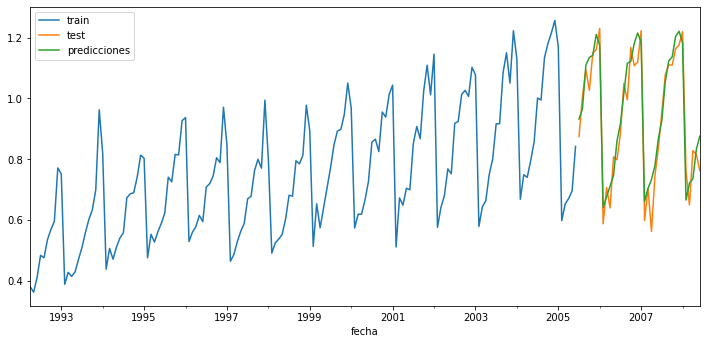

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 5.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

## Forecasting con predictores custom

In [ ]:
# Función custom para crear los predictores (fila a fila)
# ==============================================================================
def create_predictors(y):
    """
    Create first 10 lags of a time series. 
    Calculate moving average with window 20.
    """
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])

    return predictors

# Crear y ajustar forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                 regressor        = LGBMRegressor(random_state=123),
                 fun_predictors   = create_predictors, # función para crear predictores
                 window_size      = 20,                # ventana observaciones necesita la función
                 transformer_y    = None,
                 transformer_exog = None,
                 weight_func      = None
             )

forecaster.fit(y=data_train['y'], exog=None)

# Predicciones
# ==============================================================================
steps = 36 # steps a predecir, 36 meses
predicciones = forecaster.predict(steps=steps, last_window=None)

## Forecasting autorregresivo direct

In [ ]:
# Crear y ajustar Forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = Ridge(random_state=123),
                 steps            = 36,    # cantidad de regresores, 1 regresor por step
                 lags             = 15,
                 transformer_y    = None,
                 transformer_exog = None,
                 weight_func      = None
             )

forecaster.fit(y=data_train['y'], exog=None)

# Predicciones
# ==============================================================================
steps = 36 # steps a predecir, 36 meses
predicciones = forecaster.predict(steps=steps, last_window=None)

## Validación de modelos (backtesting)

Caso de uso:

- Reentrenamiento cada 12 meses con una cantidad fija de observaciones.
- Predicción de 12 meses siguientes. (steps)

<p align="center"><img src="https://joaquinamatrodrigo.github.io/skforecast/0.6.0/img/backtesting_refit_fixed_train_size.gif" style="width: 600px;"/></p>

In [ ]:
# Partición de datos en entrenamiento y test
# ==============================================================================
print(f"Fechas train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Fechas test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = RandomForestRegressor(random_state=123),
                 lags             = 12, 
                 transformer_y    = StandardScaler(), # Aplicamos un StandardScaler a la serie y
                 transformer_exog = None,
                 weight_func      = None
             )

metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,            # forecaster
                                   y                  = data['y'],             # serie completa
                                   exog               = None,                  # variables exógenas
                                   steps              = 12,                    # nº steps a predecir
                                   metric             = 'mean_absolute_error', # métrica
                                   initial_train_size = len(data_train),       # observaciones para entrenamiento inicial
                                   fixed_train_size   = True,                  # fix/moving train size
                                   refit              = True,                  # reentrenar después de cada predicción
                                   verbose            = True                   # verbose
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 159
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Data partition in fold: 1
    Training:   1993-04-01 00:00:00 -- 2006-06-01 00:00:00  (n=159)
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Data partition in fold: 2
    Training:   1994-04-01 00:00:00 -- 2007-06-01 00:00:00  (n=159)
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



Backtesting metric:  0.05843216416111114



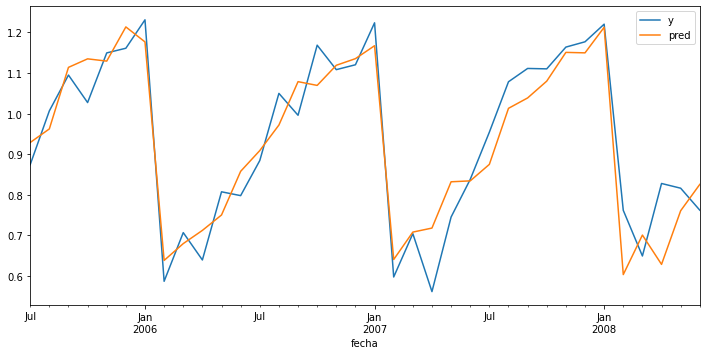

In [ ]:
# Plot Backtesting
# ==============================================================================
print('Backtesting metric: ', metric)
print('')

fig, ax = plt.subplots(figsize=(12, 5.5))
data_test['y'].plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();

## Ajuste de hiperparámetros (tuning)

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = RandomForestRegressor(random_state=123),
                 lags             = 12, # Este valor será reemplazado en el grid search
                 transformer_y    = StandardScaler(),
                 transformer_exog = None,
                 weight_func      = None
             )

# Lags utilizados como predictores
lags_grid = [6, 12, 18]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 200],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                      forecaster         = forecaster,          # forecaster
                      y                  = data['y'],           # serie completa
                      exog               = None,                # variables exógenas
                      param_grid         = param_grid,          # grid hiperparámetros
                      lags_grid          = lags_grid,           # grid lags
                      steps              = 12,                  # nº steps a predecir
                      metric             = mean_absolute_error, # callable métrica
                      initial_train_size = len(data_train),     # observaciones para entrenamiento inicial
                      fixed_train_size   = True,                # fix/moving train size
                      refit              = True,                # reentrenar después de cada predicción 
                      return_best        = True,                # reentrenar con mejor combinación el forecaster
                      verbose            = False                # Verbose False
                  )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:28<00:00,  9.52s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.05751352434480978



In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_absolute_error,max_depth,n_estimators
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",0.057514,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 200}",0.058758,5,200
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",0.059084,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 200}",0.059127,10,200
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.059335,10,100
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 200}",0.059756,10,200
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.060202,5,200
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 100}",0.060244,3,100
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.060498,5,100
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.060949,3,100


## Intervalos de predicción

In [ ]:
# Crear y ajustar Forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(random_state=123),
                 lags             = 12,
                 transformer_y    = None,
                 transformer_exog = None,
                 weight_func      = None
             )

forecaster.fit(y=data_train['y'], exog=None)

# Predecir intervalo
# ==============================================================================
predicciones = forecaster.predict_interval(
                   steps    = 36, 
                   interval = [10, 90] # Intervalo 80% entre percentiles 10 y 90
               ) 
predicciones.head(5)

,pred,lower_bound,upper_bound
2005-07-01,0.984699,0.904787,1.062151
2005-08-01,1.034904,0.960468,1.112747
2005-09-01,1.163497,1.084213,1.240968
2005-10-01,1.213971,1.133953,1.295169
2005-11-01,1.232436,1.147066,1.313195


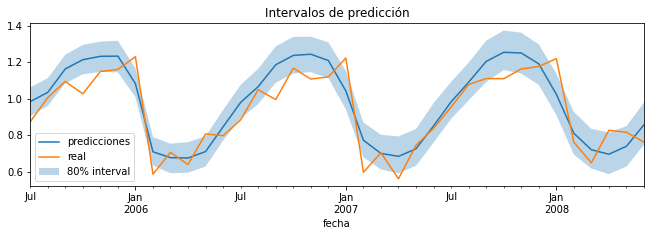

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 5.5))
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    label = '80% interval'
)
data_test['y'].plot(ax=ax, label='real')

ax.set_title('Intervalos de predicción')
ax.legend();

## Forecasting Multi-Series

In [ ]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/simulated_items_sales.csv')
data = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.head()

,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922
2012-01-04,25.895533,24.567708,27.252276
2012-01-05,21.379238,18.191667,20.357737


In [ ]:
# Crear y ajustar forecaster multi-series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = None, # posibilidad transformación individual para cada serie
                 transformer_exog   = None,
                 weight_func        = None, # pesos observaciones series según índice
                 series_weights     = None  # pesos entre series
             )

forecaster.fit(series=data, exog=None)
forecaster

ForecasterAutoregMultiSeries 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-02-16 13:36:21 
Last fit date: 2023-02-16 13:36:21 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [ ]:
# Predicción
# ==============================================================================
steps = 24

# Predictions for all items
predictions_items = forecaster.predict(steps=steps, levels=None) # levels a predecir, None==all
display(predictions_items.head(3))
print('')

# Interval predictions for item_1 and item_2
predictions_intervals = forecaster.predict_interval(steps=steps, levels=['item_1', 'item_2'])
display(predictions_intervals.head(3))

,item_1,item_2,item_3
2015-01-02,15.438024,19.316201,19.869487
2015-01-03,18.366062,19.289718,21.124993
2015-01-04,19.293743,20.497902,21.930669


,item_1,item_1_lower_bound,item_1_upper_bound,item_2,item_2_lower_bound,item_2_upper_bound
2015-01-02,15.438024,12.634531,17.770180,19.316201,15.050399,25.453347
2015-01-03,18.366062,15.312714,20.914458,19.289718,14.674289,24.709833
2015-01-04,19.293743,16.276381,21.935156,20.497902,15.970614,25.827530


## Forecasting MultiVariate

In [ ]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/guangyuan_air_pollution.csv')
data = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data = data[['CO', 'SO2', 'PM2.5']]
data.head()

,CO,SO2,PM2.5
date,,,
2013-03-01,9600.0,204.0,181.0
2013-03-02,20198.0,674.0,633.0
2013-03-03,47195.0,1661.0,1956.0
2013-03-04,15000.0,485.0,438.0
2013-03-05,59594.0,2001.0,3388.0


In [ ]:
# Crear y ajustar forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = Ridge(random_state=123),
                 level              = 'CO', # variable objetivo del forecaster (column name)
                 lags               = 7,    # permite aplicar diferentes configuraciones de lags para cada serie
                 steps              = 7,    # cantidad de regresores, 1 regresor por step
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data, exog=None)
forecaster

ForecasterAutoregMultiVariate 
Regressor: Ridge(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: None 
Transformer for exog: None 
Window size: 7 
Multivariate series (names): ['CO', 'SO2', 'PM2.5'] 
Maximum steps predicted: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-28 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-02-16 13:36:24 
Last fit date: 2023-02-16 13:36:24 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [ ]:
# Predict MultiVariate
# ==============================================================================
predicciones = forecaster.predict(steps=None)
display(predicciones)

,CO
2017-03-01,17867.240008
2017-03-02,21927.994455
2017-03-03,24697.806497
2017-03-04,25992.799455
2017-03-05,23990.418735
2017-03-06,24167.213772
2017-03-07,25660.075848


Los forecasters para múltiples series siguen la misma API para la validación y ajuste de hiperparámetro. Estas funciones se puede encontrar en el módulo `model_selection_multiseries`:
+ `backtesting_forecaster_multiseries`
+ `grid_search_forecaster_multiseries`
+ `random_search_forecaster_multiseries`
